## Sample的正确性

In [69]:
from sampler import Sampler

sampler=Sampler(20,2,0.5)
pos_batch, filted_batch_size = sampler.batch_sample(30)
print(pos_batch)

## 画3D散点图
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
pos_batch_flatten=pos_batch.view(-1,3)
x=pos_batch_flatten[:,0]
y=pos_batch_flatten[:,1]
z=pos_batch_flatten[:,2]
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(x, y, z, c='green', marker='o')
plt.show()

tensor([[[0.9808, 1.2018, 0.1419],
         [0.6462, 0.2772, 1.2685],
         [0.5887, 0.9806, 1.3689],
         ...,
         [0.0052, 0.0019, 0.8817],
         [1.4459, 1.3723, 0.2514],
         [0.1806, 0.4077, 1.1030]],

        [[0.1969, 0.5100, 0.0463],
         [0.5838, 0.8219, 0.6362],
         [0.8584, 0.3174, 0.2496],
         ...,
         [1.2409, 0.9040, 0.0174],
         [1.1769, 0.3627, 0.6026],
         [1.2115, 1.0042, 0.0306]],

        [[0.2792, 0.1853, 0.7397],
         [0.8845, 0.2179, 0.0816],
         [0.4434, 0.7330, 0.2593],
         ...,
         [0.6133, 0.1997, 0.2999],
         [0.0504, 1.3812, 1.7505],
         [0.8356, 0.7195, 0.5324]],

        ...,

        [[1.0681, 0.1315, 0.0119],
         [0.1957, 0.5716, 1.3428],
         [0.0333, 0.4470, 0.2059],
         ...,
         [0.1474, 0.0571, 0.1943],
         [0.3223, 1.1922, 0.5203],
         [0.1746, 0.2385, 0.3128]],

        [[0.1016, 0.1008, 0.0243],
         [0.4121, 1.0278, 0.0160],
         [1.

In [66]:
from sampler import batch_filt

pos_batch = torch.rand(25, 20, 3)
pos_batch=pos_batch
scale_batch=(torch.rand(25, 20, 3)*2)
pos_batch = pos_batch*2*scale_batch-scale_batch
# print(pos_batch)
filted_batch_data, filted_batch_size = batch_filt(pos_batch, 25, 20, 0.5)
print(filted_batch_data)

tensor([[[ 3.7363e-01, -9.2444e-01, -4.1346e-04],
         [ 6.5138e-01,  3.9272e-02, -6.1228e-01],
         [ 2.5133e-01, -6.5546e-02,  9.4001e-02],
         ...,
         [-2.3563e-02,  5.3360e-01,  8.7474e-02],
         [ 2.8299e-01,  5.4165e-01, -4.5922e-01],
         [ 5.0018e-03,  9.7506e-01,  8.1057e-01]],

        [[ 3.7274e-01, -1.3709e-01, -4.2445e-01],
         [-5.1922e-01,  1.0173e+00, -3.3092e-01],
         [ 1.0876e-01, -5.2103e-01,  2.6296e-01],
         ...,
         [-3.4881e-02,  1.9256e-01, -4.7346e-01],
         [ 1.6053e-02,  1.5298e+00, -1.4730e-04],
         [-1.2874e+00, -2.9585e-01,  6.8290e-02]],

        [[-3.1859e-01,  3.7630e-01,  1.5188e+00],
         [ 2.3542e-01, -3.2952e-01,  1.1852e-01],
         [-2.0353e-01, -1.7744e-01,  1.0088e+00],
         ...,
         [-8.4323e-01,  8.9588e-02, -3.4329e-02],
         [ 3.5515e-01, -1.3346e+00, -8.9041e-01],
         [-4.7066e-02, -7.1843e-02,  4.8237e-01]],

        ...,

        [[-2.6635e-01,  9.3167e-01, -6

In [50]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

def plot_3d(system):
    x=system[:,0]
    y=system[:,1]
    z=system[:,2]
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.scatter3D(x, y, z, c='green', marker='o')
    plt.show()

## 构造随机旋转并验证 Invariance

In [70]:
# ! pip install scipy

In [89]:
from scipy.spatial.transform import Rotation as R
import numpy as np
import torch
quaternion = np.random.rand(4)
quaternion /= np.linalg.norm(quaternion)
print(quaternion.tolist())
r = R.from_quat(quaternion.tolist())
print(r.as_euler('xyz',degrees=True))
matrix=r.as_matrix()
print(matrix)
matrix=torch.FloatTensor(matrix)

[0.4939810074782747, 0.7486731761825873, 0.03476151441029617, 0.44075262521206626]
[141.32580483  38.72743506  99.10414856]
[[-0.12343978  0.7090182   0.69430239]
 [ 0.77030312  0.5095488  -0.38339682]
 [-0.62561628  0.48749688 -0.60905752]]


tensor([0.9312, 0.4426, 1.0948, 1.1040, 0.6782, 1.3597, 0.5871, 0.8161, 0.8781,
        1.4839])


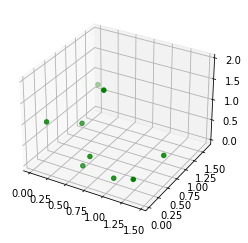

tensor([0.9312, 0.4426, 1.0948, 1.1040, 0.6782, 1.3597, 0.5871, 0.8161, 0.8781,
        1.4839])


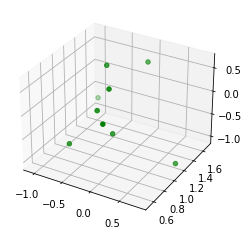

In [107]:
## 检查旋转前后边长不变

pos_batch = torch.rand(9, 3)
scale_batch=(torch.rand(9, 3)*3)
pos_batch = pos_batch*scale_batch

edge_index=torch.tensor([[0,0,0,0,1,1,1,2,2,3],
                        [1,2,3,4,2,3,4,3,4,4]])
row=pos_batch[edge_index[0]]
col=pos_batch[edge_index[1]]
radial=torch.norm(row-col, dim=1)
print(radial)
plot_3d(pos_batch)

rot_pos=torch.matmul(pos_batch,matrix)
row=rot_pos[edge_index[0]]
col=rot_pos[edge_index[1]]
radial=torch.norm(row-col, dim=1)
print(radial)
plot_3d(rot_pos)

In [117]:
from model.ignn import IGNN
import torch.nn as nn
from utils.graph_utils import get_edges_batch

device=torch.device("cuda:0")

params = {"device": device,
            "lr": 0.0,
            "num_nodes": 3,
            "in_node_attr_dim": 1,
            "node_attr_dim": 128,
            "out_node_attr_dim": 1,
            "egde_attr_dim": 1,
            "message_dim": 128,
            "global_layer_size": 64,
            "num_layers": 8,
            "activation": nn.SiLU(),
            "residual": True,
            "attention": True,
            "normalize": True,
            "tanh": False,
            "last_sigmoid": False}

ignn=IGNN(**params)

def weight_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.constant_(m.bias, 0.0)

ignn.apply(weight_init)

def random_rotate(system_3d):
    quaternion = np.random.rand(4)
    quaternion /= np.linalg.norm(quaternion)
    r = R.from_quat(quaternion.tolist())
    matrix=r.as_matrix()
    matrix=torch.FloatTensor(matrix)
    system_3d=torch.matmul(system_3d,matrix)
    return system_3d

for i in range(10):
    pos_batch = torch.rand(9, 3)
    scale_batch=(torch.rand(9, 3)*3)
    pos_batch = pos_batch*scale_batch
    rot_pos=random_rotate(pos_batch)
    pos_batch=pos_batch.to(device)
    h = torch.ones(9, 1).to(device)
    edge_index, edge_attr = get_edges_batch(3, 3)
    edge_index = edge_index.to(device)
    edge_attr = edge_attr.to(device)
    a=ignn(pos_batch, h, edge_index, edge_attr)
    print(a)

    rot_pos=rot_pos.to(device)
    h = torch.ones(9, 1).to(device)
    edge_index, edge_attr = get_edges_batch(3, 3)
    edge_index = edge_index.to(device)
    edge_attr = edge_attr.to(device)

    a=ignn(rot_pos, h, edge_index, edge_attr)
    print(a)
    print("==================")


tensor([[0.0264],
        [0.0262],
        [0.0266]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[0.0264],
        [0.0262],
        [0.0266]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[0.0262],
        [0.0224],
        [0.0269]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[0.0262],
        [0.0224],
        [0.0269]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[0.0272],
        [0.0256],
        [0.0266]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[0.0272],
        [0.0256],
        [0.0266]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[0.0234],
        [0.0256],
        [0.0251]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[0.0234],
        [0.0256],
        [0.0251]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[0.0191],
        [0.0239],
        [0.0264]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[0.0191],
        [0.0239],
        [0.0264]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[0.0262],
  

## 验证 BFGS 的 Invariance

In [157]:
from bfgs_relax import relax,batch_relax

pos_batch = torch.rand(90, 3)
scale_batch=(torch.rand(90, 3)*3)
pos_batch = pos_batch*scale_batch
rot_pos=random_rotate(pos_batch)

pos_batch=pos_batch.view(3,30,3)
batch_steps,batch_energy=batch_relax(pos_batch,500,3)
print(batch_steps)
print(batch_energy)

rot_pos=rot_pos.view(3,30,3)
batch_steps,batch_energy=batch_relax(rot_pos,500,3)
print(batch_steps)

print(batch_energy)

KeyboardInterrupt: 

Bad pipe message: %s [b'\x87\xcb\x1a\xb0\xd3\x06\x87\xb8\xa3\xc7<]\x02Ca`\xdbI', b'\xd6\xda\x13\x8c\x90\xe2\x0f\xf9\xb8\x14\xe9;;\xee\xa0\xbfp\xa2}r\x07~\x83\x1f)L\xb8iKN\x00']
Bad pipe message: %s [b'\xc9u3\xa1\x08\x8f\xfe\x98L\xbd\n\x1f\xcc\xfa\xeb]\xebO i\xd2\x95&\xbe\xf8\x85t\xd9UH\xac\x9b\xfc\xe3\x9b_\xcar\x9e9\xa3:\xd9Wn\xe1|\x99\xfb\xaf\xb2\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00']
Bad pipe message: %s [b'|4\x8b/\x88QX\x05\xe4\x11\x92\x17\xd2\x01\xd0\xb4\x07@\x00\x00\xa2\xc0\x14\xc0\n\x009\x008\x007\x006\x00\x88\x00\x87\x00\x86\x00\x85\xc0\x19\x00:\x00\x89\xc0\x0f\xc0\x05\x005\x00\x84\xc0\x13\xc0\t\x003\x002\x001\x000\x00\x9a\x00\x99\x00\x98\x00\x97\x00E\x00D\x00C\x00B\xc0\x18\x004\x00\x9b\x00F\xc0\x0e\xc0\x04\x00/\x00\x96\x00A\x00\x07\xc0\x11\xc0\x07\xc0\x16\x00\x18\xc0\x0c\xc0\x02\x00\x05\x00\x04\xc0\x12\xc0\x08\x00\x16\x00\x13\x00\x10\x00']
Bad pipe message: %s [b'\x17\x00\x1b\xc0\r\xc0\x03\x00\n\x00\x15\x00']
Bad pipe message: %s [b'\x0f\x00\x0c\x00\x1a\x00\t\x00\x14

## 保存训练模型

In [75]:
from discriminator import Discriminator
import torch


lr=1e-4
pos_scale=10
num_steps=101
num_atoms=20
batch_size=128
in_node_attr_dim=1
node_attr_dim=128
out_node_attr_dim=1
edge_attr_dim=1
message_dim=128
num_layers=8
global_layer_size=64
residual=True
attention=True
normalize=True
tanh=True

target_latent_size=128
target_num_layers=4
target_out_put_size=1

max_relax_steps=200
threshold=0.5
potential_scale=100

device = torch.device("cuda:0")

intrinsic_target_params={"device": device,
                          "lr": lr,
                          "num_nodes": num_atoms,
                          "in_node_attr_dim": in_node_attr_dim,
                          "node_attr_dim": node_attr_dim,
                          "out_node_attr_dim": out_node_attr_dim,
                          "egde_attr_dim": edge_attr_dim,
                          "message_dim": message_dim,
                          "global_layer_size": global_layer_size,
                          "num_layers": target_num_layers,
                          "activation": nn.SiLU(),
                          "residual": residual,
                          "attention": attention,
                          "normalize": normalize,
                          "tanh": tanh,
                          "last_sigmoid": False}

intrinsic_model_params = {"device": device,
                          "lr": lr,
                          "num_nodes": num_atoms,
                          "in_node_attr_dim": in_node_attr_dim,
                          "node_attr_dim": node_attr_dim,
                          "out_node_attr_dim": out_node_attr_dim,
                          "egde_attr_dim": edge_attr_dim,
                          "message_dim": message_dim,
                          "global_layer_size": global_layer_size,
                          "num_layers": num_layers,
                          "activation": nn.SiLU(),
                          "residual": residual,
                          "attention": attention,
                          "normalize": normalize,
                          "tanh": tanh,
                          "last_sigmoid": False}

extrinsic_model_params = {"device": device,
                      "lr": lr,
                      "num_nodes": num_atoms,
                      "in_node_attr_dim": in_node_attr_dim,
                      "node_attr_dim": node_attr_dim,
                      "out_node_attr_dim": out_node_attr_dim,
                      "egde_attr_dim": edge_attr_dim,
                      "message_dim": message_dim,
                      "global_layer_size": global_layer_size,
                      "num_layers": num_layers,
                      "activation": nn.SiLU(),
                      "residual": residual,
                      "attention": attention,
                      "normalize": normalize,
                      "tanh": tanh,
                      "last_sigmoid": False}


discriminator = Discriminator(intrinsic_target_params,
                                  intrinsic_model_params,
                                  extrinsic_model_params,
                                  20,
                                  device)

# discriminator.load_model("./model_save/")
# discriminator.intrinsic_model.load_state_dict(torch.load("./model_save/" + "intrinsic_model.pt"))
# discriminator.intrinsic_target_model.load_state_dict(torch.load("./model_save/" + "intrinsic_target_model.pt"))
# discriminator.extrinsic_model.load_state_dict(torch.load("./model_save/" + "extrinsic_model.pt"))

<All keys matched successfully>

## Test 测试


In [23]:
from discriminator import Discriminator
import torch
import torch.nn as nn

lr=1e-4
pos_scale=2
num_steps=101
num_atoms=20
batch_size=128
in_node_attr_dim=1
node_attr_dim=128
out_node_attr_dim=1
edge_attr_dim=1
message_dim=128
num_layers=8
global_layer_size=128
residual=True
attention=True
normalize=True
tanh=True

target_latent_size=128
target_num_layers=4
target_out_put_size=1

max_relax_steps=200
threshold=1
potential_scale=100

device = torch.device("cuda:0")

intrinsic_target_params={"device": device,
                          "lr": lr,
                          "num_nodes": num_atoms,
                          "in_node_attr_dim": in_node_attr_dim,
                          "node_attr_dim": node_attr_dim,
                          "out_node_attr_dim": out_node_attr_dim,
                          "egde_attr_dim": edge_attr_dim,
                          "message_dim": message_dim,
                          "global_layer_size": global_layer_size,
                          "num_layers": target_num_layers,
                          "activation": nn.SiLU(),
                          "residual": residual,
                          "attention": attention,
                          "normalize": normalize,
                          "tanh": tanh,
                          "last_sigmoid": False}

intrinsic_model_params = {"device": device,
                          "lr": lr,
                          "num_nodes": num_atoms,
                          "in_node_attr_dim": in_node_attr_dim,
                          "node_attr_dim": node_attr_dim,
                          "out_node_attr_dim": out_node_attr_dim,
                          "egde_attr_dim": edge_attr_dim,
                          "message_dim": message_dim,
                          "global_layer_size": global_layer_size,
                          "num_layers": num_layers,
                          "activation": nn.SiLU(),
                          "residual": residual,
                          "attention": attention,
                          "normalize": normalize,
                          "tanh": tanh,
                          "last_sigmoid": False}

extrinsic_model_params = {"device": device,
                      "lr": lr,
                      "num_nodes": num_atoms,
                      "in_node_attr_dim": in_node_attr_dim,
                      "node_attr_dim": node_attr_dim,
                      "out_node_attr_dim": out_node_attr_dim,
                      "egde_attr_dim": edge_attr_dim,
                      "message_dim": message_dim,
                      "global_layer_size": global_layer_size,
                      "num_layers": num_layers,
                      "activation": nn.SiLU(),
                      "residual": residual,
                      "attention": attention,
                      "normalize": normalize,
                      "tanh": tanh,
                      "last_sigmoid": False}


discriminator = Discriminator(intrinsic_target_params,
                                  intrinsic_model_params,
                                  extrinsic_model_params,
                                  num_atoms,
                                  20,
                                  0.5,
                                  device)

discriminator.intrinsic_model.load_state_dict(torch.load("./model_save/multistep1_" + "intrinsic_model.pt"))
discriminator.intrinsic_target_model.load_state_dict(torch.load("./model_save/multistep1_" + "intrinsic_target_model.pt"))
discriminator.extrinsic_model.load_state_dict(torch.load("./model_save/multistep1_" + "extrinsic_model.pt"))

<All keys matched successfully>

In [24]:
from sampler import Sampler

sampler = Sampler(num_atoms, pos_scale, threshold)

In [25]:
from bfgs_relax import batch_compute

conforms,sampled_batch_size = sampler.batch_sample(batch_size)
relax_energy=batch_compute(conforms,sampled_batch_size)
print(relax_energy)
relax_energy=torch.FloatTensor(relax_energy).unsqueeze(-1)

[-24.899318511447483, -24.936875974558806, -18.835912224286194, -14.57733548285998, -21.0211937649682, -21.98243367126957, -17.202056480363684, -21.171612469452942, -16.374374015263214, -19.24951458457686, -12.017175888051241, -16.68259426248399, -16.163441116052976, -15.948588105390339, -17.701050805261442, -13.752256353053433, -21.837386519441587, -19.761851564615466, -15.100776627598666, -16.21818076701084, -18.18779554887753, -17.027763263655576, -14.164745203837438, -16.43371570325065, -20.602926438363536, -16.586357657665797, -13.615209749316236, -16.734420271473752, -20.556565021145303, -16.523785747661417, -17.19370714922425, -19.908316568120288, -15.027545438635281, -19.671375833200592, -13.76677319904681, -15.561742953868178, -16.377311405077915, -17.7732641320517, -19.649882967952568, -21.77238546471411, -14.99089294189808, -17.649820376723582, -22.209883626474937, -20.248484748946346, -18.590879353530976, -17.076004280279435, -15.930020410773405, -16.456619100858962, -15.16

In [26]:
intrinsic_loss,extrinsic_loss,intrinsic_reward,extrinsic_reward=discriminator.compute_loss_and_train(conforms, relax_energy, sampled_batch_size)

In [27]:
print(extrinsic_loss)
print(intrinsic_loss)
# print(extrinsic_reward)
print(intrinsic_reward)

2.210385799407959
0.029411232098937035
[0.08763490617275238, 0.007908433675765991, 0.11038058996200562, 0.17412692308425903, 0.15179194509983063, 0.03671661391854286, 0.2931576073169708, 0.14578700065612793, 0.04523949697613716, 0.1909833699464798, 0.32022279500961304, 0.2204337865114212, 0.17241880297660828, 0.16147546470165253, 0.35879528522491455, 0.0829722136259079, 0.05500449240207672, 0.3192843794822693, 0.2622835040092468, 0.08249656856060028, 0.1611534208059311, 0.1149730235338211, 0.1725166141986847, 0.33343321084976196, 0.12334668636322021, 0.0007190704345703125, 0.06960080564022064, 0.24254071712493896, 0.004564601927995682, 0.2607922852039337, 0.026458989828824997, 0.013488024473190308, 0.09436482191085815, 0.22171565890312195, 0.06804652512073517, 0.02175752818584442, 0.11568853259086609, 0.08252842724323273, 0.18603958189487457, 0.1645369678735733, 0.06631053984165192, 0.0052661895751953125, 0.06827469170093536, 0.04876882582902908, 0.14714516699314117, 0.1390552073717117

In [28]:
import matplotlib.pyplot as plt
def plot_list(list1,list2,label_1,label_2):
    plt.plot(list1,label=label_1,color="blue")
    plt.plot(list2,label=label_2,color="red")
    plt.show()

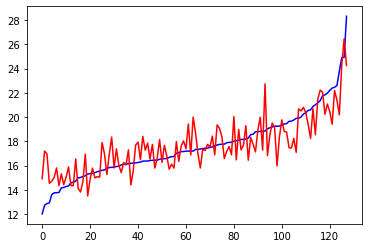

In [29]:
import numpy as np

reward_cat=np.vstack((np.add(extrinsic_reward,intrinsic_reward).tolist(),-relax_energy.squeeze(-1).numpy()))
reward_cat=reward_cat[:,np.argsort(reward_cat[1,:])]
plot_list(reward_cat[1,:].tolist(),reward_cat[0,:].tolist(),"real_energy","predicted_reward")

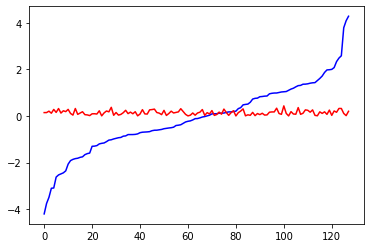

In [30]:
dis=np.add(relax_energy.squeeze(-1).tolist(),extrinsic_reward).tolist()
dis_cat=np.vstack((dis,intrinsic_reward))
dis_cat=dis_cat[:,np.argsort(dis_cat[0,:])]
plot_list(dis_cat[0].tolist(),dis_cat[1].tolist(),"dis","in")

## 对于 Sampler 的优化

In [36]:
import torch
from bfgs_relax import batch_compute
import numpy as np

class Sampler():
    def __init__(self,num_atoms,pos_scale,threshold):
        self.num_atoms=num_atoms
        self.pos_scale=pos_scale
        self.threshold=threshold
    
    def single_sample(self):
        pos=torch.zeros(self.num_atoms,3)
        for i in range(self.num_atoms):
            # new_pos=torch.rand(3)*2*self.pos_scale-self.pos_scale
            # if_continue=False
            # for j in range(i):
            #     distance=torch.norm(new_pos-pos[j],p=2)
            #     if distance<self.threshold:
            #         if_continue=True
            #         break
            if_continue=True
            while if_continue:
                new_pos=torch.rand(3)*2*self.pos_scale-self.pos_scale
                if_continue=False
                for j in range(i):
                    distance=torch.norm(new_pos-pos[j],p=2)
                    if distance<self.threshold:
                        if_continue=True
                        break
            pos[i,:]=new_pos
        return pos

    def batch_sample(self,batch_size):
        conforms=torch.zeros(batch_size,self.num_atoms,3)
        for i in range(batch_size):
            conforms[i,:,:]=self.single_sample()
            # print("sampled "+str(i)+"th")
        return conforms,batch_size



In [40]:
sampler=Sampler(60,3,1)
conforms,sampled_batch_size=sampler.batch_sample(200)
relax_energy=batch_compute(conforms,sampled_batch_size)
print(np.min(relax_energy).item())

-76.83455412870273


In [14]:
new_pos=torch.rand(3)*2
print(new_pos)

pos=torch.zeros(5,3)
print(pos[1])

distance=torch.norm(new_pos-pos[1],p=2)
print(distance)

tensor([0.8910, 0.3788, 0.8308])
tensor([0., 0., 0.])
tensor(1.2757)


## 检查 graph_utils 里面的 edge_index

In [5]:
from utils.graph_utils import get_edges_batch
import torch

conforms=torch.rand(5,5,3)
pos=conforms.view(-1,3)

edge_index,_=get_edges_batch(conforms.shape[1],conforms.shape[0])
print(edge_index)

distance_edge=torch.norm(pos[edge_index[0]]-pos[edge_index[1]],p=2,dim=1)
print(distance_edge)

distance_node=torch.zeros((conforms.shape[0]*conforms.shape[1],conforms.shape[1]-1))
for i in range(conforms.shape[0]*conforms.shape[1]):
    distance_node[i]=torch.FloatTensor([distance_edge[j] for j in range((i*(conforms.shape[1]-1)),((i+1)*(conforms.shape[1]-1)))])

print(distance_node)

tensor([[ 0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2,  3,  3,  3,  3,  4,  4,
          4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,  7,  7,  8,  8,  8,  8,
          9,  9,  9,  9, 10, 10, 10, 10, 11, 11, 11, 11, 12, 12, 12, 12, 13, 13,
         13, 13, 14, 14, 14, 14, 15, 15, 15, 15, 16, 16, 16, 16, 17, 17, 17, 17,
         18, 18, 18, 18, 19, 19, 19, 19, 20, 20, 20, 20, 21, 21, 21, 21, 22, 22,
         22, 22, 23, 23, 23, 23, 24, 24, 24, 24],
        [ 1,  2,  3,  4,  0,  2,  3,  4,  0,  1,  3,  4,  0,  1,  2,  4,  0,  1,
          2,  3,  6,  7,  8,  9,  5,  7,  8,  9,  5,  6,  8,  9,  5,  6,  7,  9,
          5,  6,  7,  8, 11, 12, 13, 14, 10, 12, 13, 14, 10, 11, 13, 14, 10, 11,
         12, 14, 10, 11, 12, 13, 16, 17, 18, 19, 15, 17, 18, 19, 15, 16, 18, 19,
         15, 16, 17, 19, 15, 16, 17, 18, 21, 22, 23, 24, 20, 22, 23, 24, 20, 21,
         23, 24, 20, 21, 22, 24, 20, 21, 22, 23]])
tensor([0.8412, 0.4149, 1.0461, 0.9463, 0.8412, 0.8642, 0.7003, 0.5845, 0.4149,
        0

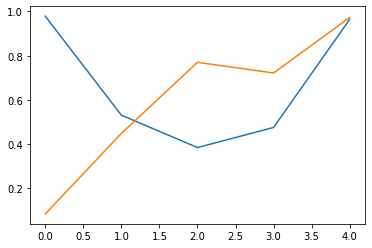

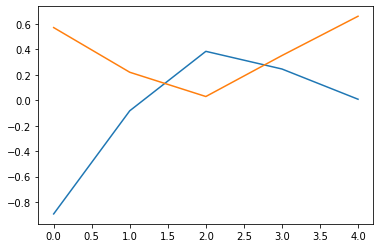

In [1]:
import matplotlib.pyplot as plt
import numpy as np

energy=np.random.rand(5)
extrinsic_rewards=np.random.rand(5).tolist()
intrinsic_rewards=np.random.rand(5).tolist()

plt.figure()
plt.plot(energy.tolist(),label="real energy")
plt.plot(extrinsic_rewards,label="prediction")
plt.show()
plt.figure()
plt.plot(np.add((-energy).tolist(),extrinsic_rewards),label="real res")
plt.plot(intrinsic_rewards,label="prediction")
plt.show()